## Biblioteca

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings("ignore")

## Função

In [3]:
def cross_validation_func(db, model, k=10):

    i = 1
    df = pd.DataFrame()
    data = db.assign(seed=lambda x: np.random.randint(1, k+1, x.shape[0]))

    while i <= k:  
        X_train = data.pipe(lambda x: x[x.seed != i]).drop(["id", "target", "seed"], 1)
        y_train = data.pipe(lambda x: x[x.seed != i]).loc[:, ["target"]]

        X_test = data.pipe(lambda x: x[x.seed == i]).drop(["id", "target", "seed"], 1)
        y_test = data.pipe(lambda x: x[x.seed == i]).loc[:, ["target"]]

        result = model.fit(X_train, y_train)

        from sklearn.metrics import accuracy_score
        from sklearn.metrics import roc_auc_score
        acc = accuracy_score(y_test, result.predict(X_test))
        auc = roc_auc_score(y_test, result.predict_proba(X_test)[:, 1])
        
        df_data = pd.DataFrame(columns=['seed', 'accuracy_score', 'auc'], 
                           data=[[i, acc, auc]])
        df = pd.concat([df, df_data])

        i+=1
    return df

## Data

In [4]:
dados_treino = pd.read_csv("porto_seguro_limpo_treino.csv")
dados_teste = pd.read_csv("porto_seguro_limpo_teste.csv")

In [5]:
X_treino = dados_treino.drop(["id", "target"], 1)
y_treino = dados_treino.loc[:, ["target"]]

X_teste = dados_teste.drop(["id", "target"], 1)
y_teste = dados_teste.loc[:, ["target"]]

In [6]:
data = pd.concat([dados_teste, dados_treino])

## Logistic Regression

In [5]:
data_stepwise = pd.concat([pd.read_csv("porto_seguro_stepwise_reagrupado_treino.csv"), 
                           pd.read_csv("porto_seguro_stepwise_reagrupado_teste.csv")]).drop(["ps_car_05_cat_0_1"], 1)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e9)
k = 10

cv_reglog = cross_validation_func(data_stepwise, model, k)
print("accuracy_score: %0.4f (+/- %0.4f)" % (cv_reglog.accuracy_score.mean(), cv_reglog.accuracy_score.std() * 2))
print("auc: %0.4f (+/- %0.4f)" % (cv_reglog.auc.mean(), cv_reglog.auc.std() * 2))

accuracy_score: 0.9636 (+/- 0.0014)
auc: 0.6290 (+/- 0.0135)


## Decision Tree Classifier

In [6]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, min_samples_split=7)
k = 10

cv_tree = cross_validation_func(data, model, k)
print("accuracy_score: %0.4f (+/- %0.4f)" % (cv_tree.accuracy_score.mean(), cv_tree.accuracy_score.std() * 2))
print("auc: %0.4f (+/- %0.4f)" % (cv_tree.auc.mean(), cv_tree.auc.std() * 2))

accuracy_score: 0.9635 (+/- 0.0018)
auc: 0.6027 (+/- 0.0081)


In [7]:
sns.set(rc={'figure.figsize':(25,20)})
sns.set_style("whitegrid")
sns.set_palette("husl")

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, min_samples_split=7)
model.fit(X_treino, y_treino)

importances = model.feature_importances_
indices = np.argsort(importances)
features = X_treino.columns

importancia_tree = (pd
                    .DataFrame(importances[indices], features[indices])
                    .reset_index()
                    .rename(columns={"index":"variavel", 0:"importancia_da_variavel"})
                    .sort_values("importancia_da_variavel", ascending=False)
                   )

## Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=3, max_features=5)
k = 10

cv_rf = cross_validation_func(data, model, k)
print("accuracy_score: %0.4f (+/- %0.4f)" % (cv_rf.accuracy_score.mean(), cv_rf.accuracy_score.std() * 2))
print("auc: %0.4f (+/- %0.4f)" % (cv_rf.auc.mean(), cv_rf.auc.std() * 2))

accuracy_score: 0.9636 (+/- 0.0013)
auc: 0.6218 (+/- 0.0153)


In [8]:
sns.set(rc={'figure.figsize':(25,20)})
sns.set_style("whitegrid")
sns.set_palette("husl")

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=3, max_features=5)
model.fit(X_treino, y_treino)

importances = model.feature_importances_
indices = np.argsort(importances)
features = X_treino.columns

importancia_rf = (pd
                  .DataFrame(importances[indices], features[indices])
                  .reset_index()
                  .rename(columns={"index":"variavel", 0:"importancia_da_variavel"})
                  .sort_values("importancia_da_variavel", ascending=False)
                 )

## XGBoost Classifier

In [5]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate='0.1')
k = 10

cv_xgb = cross_validation_func(data, model, k)
print("accuracy_score: %0.4f (+/- %0.4f)" % (cv_xgb.accuracy_score.mean(), cv_xgb.accuracy_score.std() * 2))
print("auc: %0.4f (+/- %0.4f)" % (cv_xgb.auc.mean(), cv_xgb.auc.std() * 2))

accuracy_score: 0.9636 (+/- 0.0012)
auc: 0.6377 (+/- 0.0085)


In [9]:
sns.set(rc={'figure.figsize':(25,20)})
sns.set_style("whitegrid")
sns.set_palette("husl")

from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate='0.1')
model.fit(X_treino, y_treino)

importances = model.feature_importances_
indices = np.argsort(importances)
features = X_treino.columns

importancia_xgb = (pd
                   .DataFrame(importances[indices], features[indices])
                   .reset_index()
                   .rename(columns={"index":"variavel", 0:"importancia_da_variavel"})
                   .sort_values("importancia_da_variavel", ascending=False)
                 )

## Importância das features

In [34]:
features_importance = (
    importancia_tree.rename(columns={"importancia_da_variavel":"arvore_classificatoria"})
    .merge(importancia_rf.rename(columns={"importancia_da_variavel":"random_forest"}), 
        on="variavel", 
        how="left")
    .merge(importancia_xgb.rename(columns={"importancia_da_variavel":"xgboost"}), 
        on="variavel", 
        how="left") 
)

In [28]:
features_importance_2 = pd.concat([
    importancia_tree.assign(modelo=lambda x: "Árvore Classificatória"),
    importancia_rf.assign(modelo=lambda x: "Random Forest"),
    importancia_xgb.assign(modelo=lambda x: "XGBoost")]).rename(columns={"variavel":"Variável"})

Text(0.5,1,'Importância das variáveis')

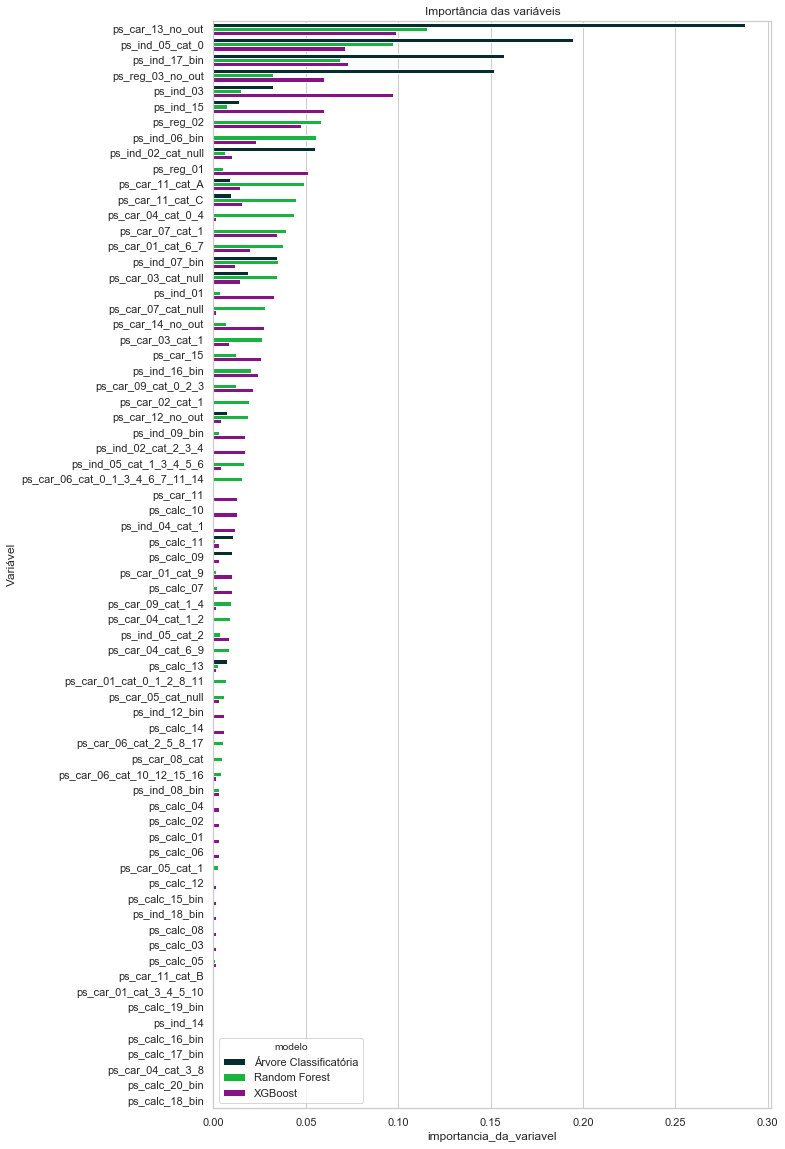

In [32]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_palette(["#003333", "#00CC33", "#990099"])

(sns
 .barplot(x="importancia_da_variavel", 
          y="Variável", 
          hue="modelo", 
          data=features_importance_2.sort_values("importancia_da_variavel", ascending=False))
 .set_title("Importância das variáveis")
)

In [40]:
sns.set(rc={'figure.figsize':(30, 20)})

corr = features_importance.sort_values("variavel").corr()
corr.style.background_gradient(cmap='coolwarm')

,arvore_classificatoria,random_forest,xgboost
arvore_classificatoria,1,0.748419,0.717473
random_forest,0.748419,1,0.655571
xgboost,0.717473,0.655571,1


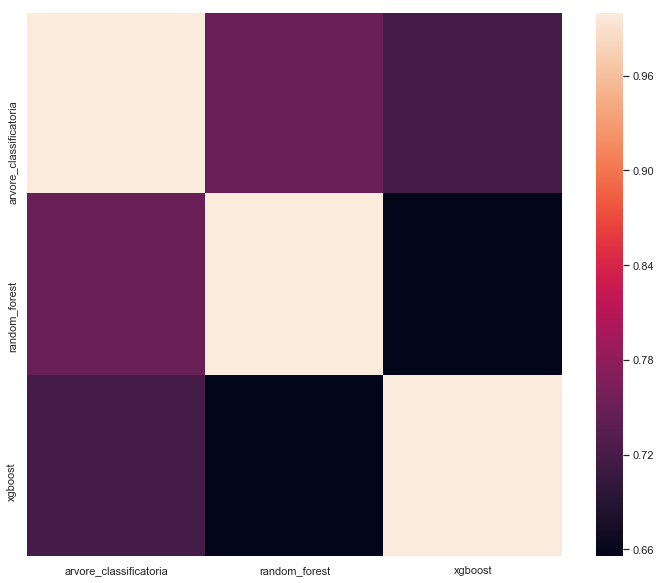

In [48]:
sns.set(rc={'figure.figsize':(12, 10)})

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)